Here is the small experiment that compares how our intervals-based spectrum looks overlayed with full data spectrum. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import logging
from pathlib import Path
from fooof.sim import gen_freqs
from fooof import FOOOF
from fooof.analysis import get_band_peak_fm
from neurodsp.spectral import compute_spectrum_welch

def gauss(mu,sigma,x):
    # lower normal part of gaussian
    normal = 1/(2.0 * np.pi * sigma**2)
    # calculating Gaussian filter
    gauss = np.exp(-((x-mu)**2 / (2.0 * sigma**2))) * normal
    return gauss

# Set up file paths
file_path = str(Path().absolute())
project_path = str(Path().absolute().parent.parent)
exp_name = file_path.split('/')[-1]

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Current file directory: {file_path}")
logging.info(f"Current project directory: {project_path}")

os.chdir(project_path)
sys.path.append(project_path)

# Import custom modules
from src.utils import parse_spectrum

2023-03-29 11:15:15,442 - INFO - Current file directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves/exp/upstates-intervals
2023-03-29 11:15:15,443 - INFO - Current project directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves


In [2]:
# Read data about interaval spectral properties
# Set input directory for data
input_dir = f"{project_path}/exp/{exp_name}/data"

# Set output directory for plots
output_dir = f"{project_path}/res/{exp_name}/spectral-properties"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Read data
data = pd.read_csv(f'{input_dir}/spectral_properties.csv')
upstate_data = data[data['State'] == 'upstate']
downstate_data = data[data['State'] == 'downstate']

# Remove nans from data
upstate_data_no_nun = upstate_data.dropna()
downstate_data_no_nun = downstate_data.dropna()

In [3]:
# Parse power spectrum from intervals and take mean value through intervals and channels

freqs_upstate_mean, powers_upstate_mean = [], []
freqs_downstate_mean, powers_downstate_mean = [], []

# Get mean values for each channel
for channel in upstate_data['Channel'].unique():
    upstate_data_ch = upstate_data[upstate_data['Channel'] == channel]
    downstate_data_ch = downstate_data[downstate_data['Channel'] == channel]

    # Get all center frequencies, bandwidths, and powers
    upstate_cf = upstate_data_ch['Central frequencies'].values
    upstate_bw = upstate_data_ch['Bandwidths'].values
    upstate_pow = upstate_data_ch['Peak powers'].values

    downstate_cf = downstate_data_ch['Central frequencies'].values
    downstate_bw = downstate_data_ch['Bandwidths'].values
    downstate_pow = downstate_data_ch['Peak powers'].values

    # Get power spectrum
    spectrum = upstate_data_ch['Power spectrum (freqs)'].values
    freqs_upstate, powers_upstate = parse_spectrum(spectrum, upstate_data_ch['Power spectrum (powers)'].values)
    freqs_upstate = np.array(freqs_upstate)
    powers_upstate = np.array(powers_upstate)

    # Get power spectrum
    spectrum = downstate_data_ch['Power spectrum (freqs)'].values
    freqs_downstate, powers_downstate = parse_spectrum(spectrum, downstate_data_ch['Power spectrum (powers)'].values)
    freqs_downstate = np.array(freqs_downstate)
    powers_downstate = np.array(powers_downstate)

    # Append to list
    freqs_upstate_mean.append(freqs_upstate)
    powers_upstate_mean.append(powers_upstate)
    
    freqs_downstate_mean.append(freqs_downstate)
    powers_downstate_mean.append(powers_downstate)

freqs_upstate_mean = np.array(freqs_upstate_mean)
powers_upstate_mean = np.array(powers_upstate_mean)
# Plot power spectrum
freqs_upstate_mean = np.mean(freqs_upstate_mean, axis=0) # mean across channels
powers_upstate_std = np.std(powers_upstate, axis=0) # std across channels
powers_upstate_mean = np.mean(powers_upstate_mean, axis=0) # mean across channels

freqs_downstate_mean = np.mean(freqs_downstate_mean, axis=0) # mean across channels
powers_downstate_std = np.std(powers_downstate_mean, axis=0)  # std across channels
powers_downstate_mean = np.mean(powers_downstate_mean, axis=0) # mean across channels

In [31]:
# Read raw ECoG data
input_dir = f"{project_path}/exp/{exp_name}/data"

files = os.listdir(input_dir)

for file in files:
    if file.endswith('.npy'):
        if file == 'ecog.npy':
            ecog_data = np.load(input_dir + '/' + file, allow_pickle=True)

# Compute ECoG mean power spectrum
spectra = []
for i in range(ecog_data.shape[0]):
    freqs, powers = compute_spectrum_welch(ecog_data[i], fs=1000, nperseg=500, f_range=(0, 100),  noverlap=0)
    spectra.append(powers)

spectra = np.array(spectra)
print(spectra.shape)
mean_power = np.mean(spectra, axis=0)

(64, 51)


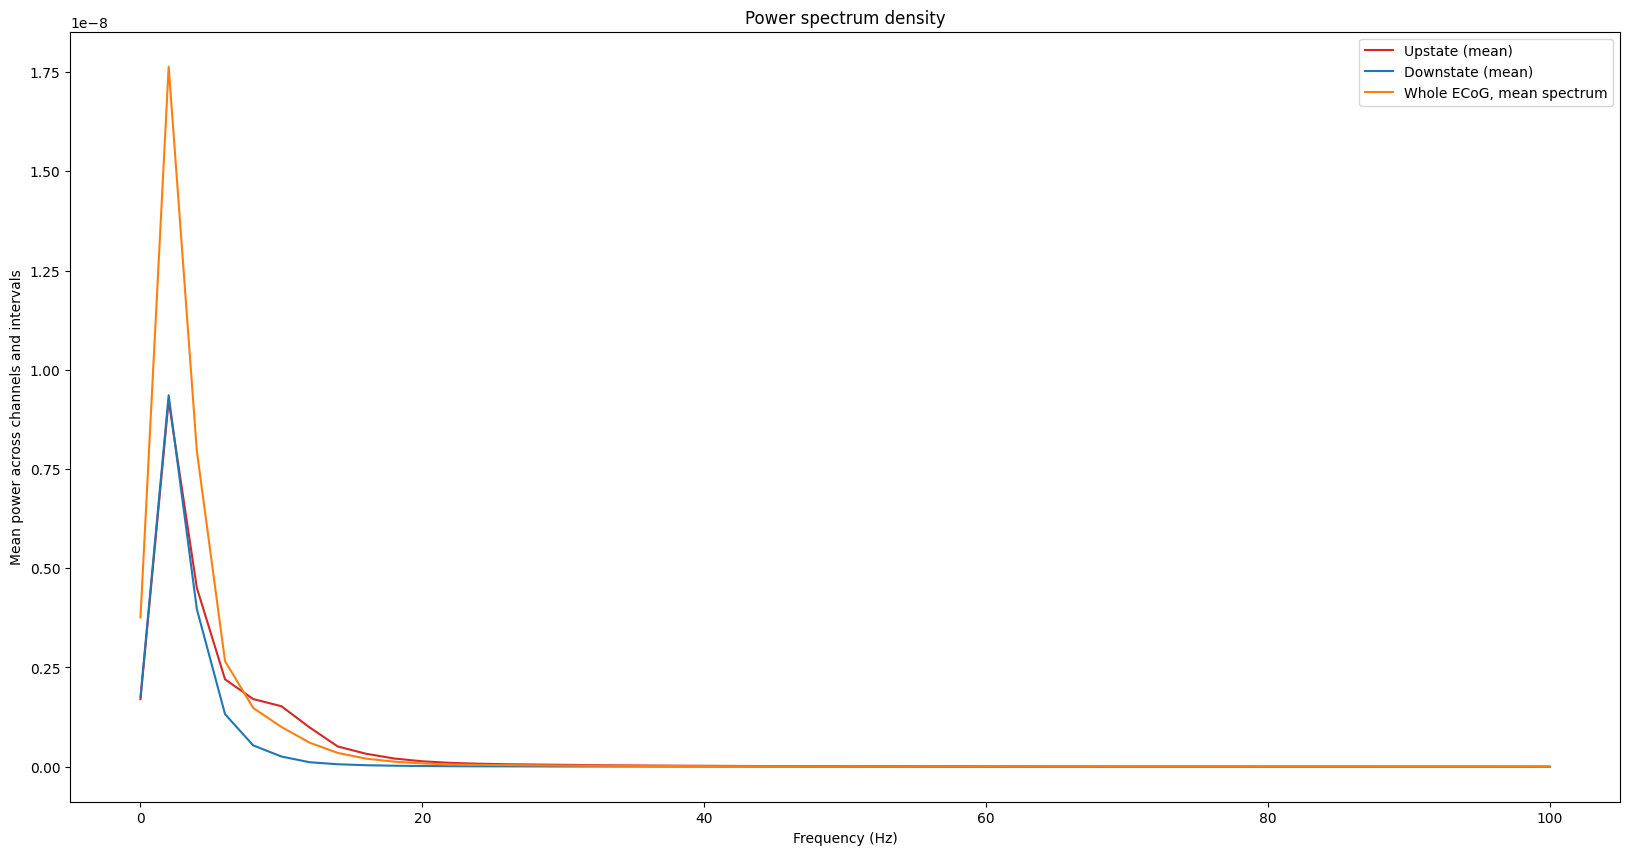

In [32]:
# Plot power spectrum for ECoG and interval-based ECoG power spectrum
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.mean(freqs_upstate_mean, axis=0), np.mean(powers_upstate_mean, axis=0), label='Upstate (mean)', color='tab:red')
# ax.fill_between(np.mean(freqs_upstate_mean, axis=0), np.mean(powers_upstate_mean, axis=0) - np.std(powers_upstate_mean, axis=0), np.mean(powers_upstate_mean, axis=0) + np.std(powers_upstate_mean, axis=0), alpha=0.5, label='Upstate (std)', color='tab:red')
ax.plot(np.mean(freqs_downstate_mean, axis=0), np.mean(powers_downstate_mean, axis=0), label='Downstate (mean)', color='tab:blue')
# ax.fill_between(np.mean(freqs_downstate_mean, axis=0), np.mean(powers_downstate_mean, axis=0) - np.std(powers_downstate_mean, axis=0), np.mean(powers_downstate_mean, axis=0) + np.std(powers_downstate_mean, axis=0), alpha=0.5, label='Downstate (std)', color='tab:blue')
ax.plot(freqs, mean_power, label='Whole ECoG, mean spectrum', color='tab:orange')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Mean power across channels and intervals')
ax.set_title('Power spectrum density')
ax.legend()
plt.show()

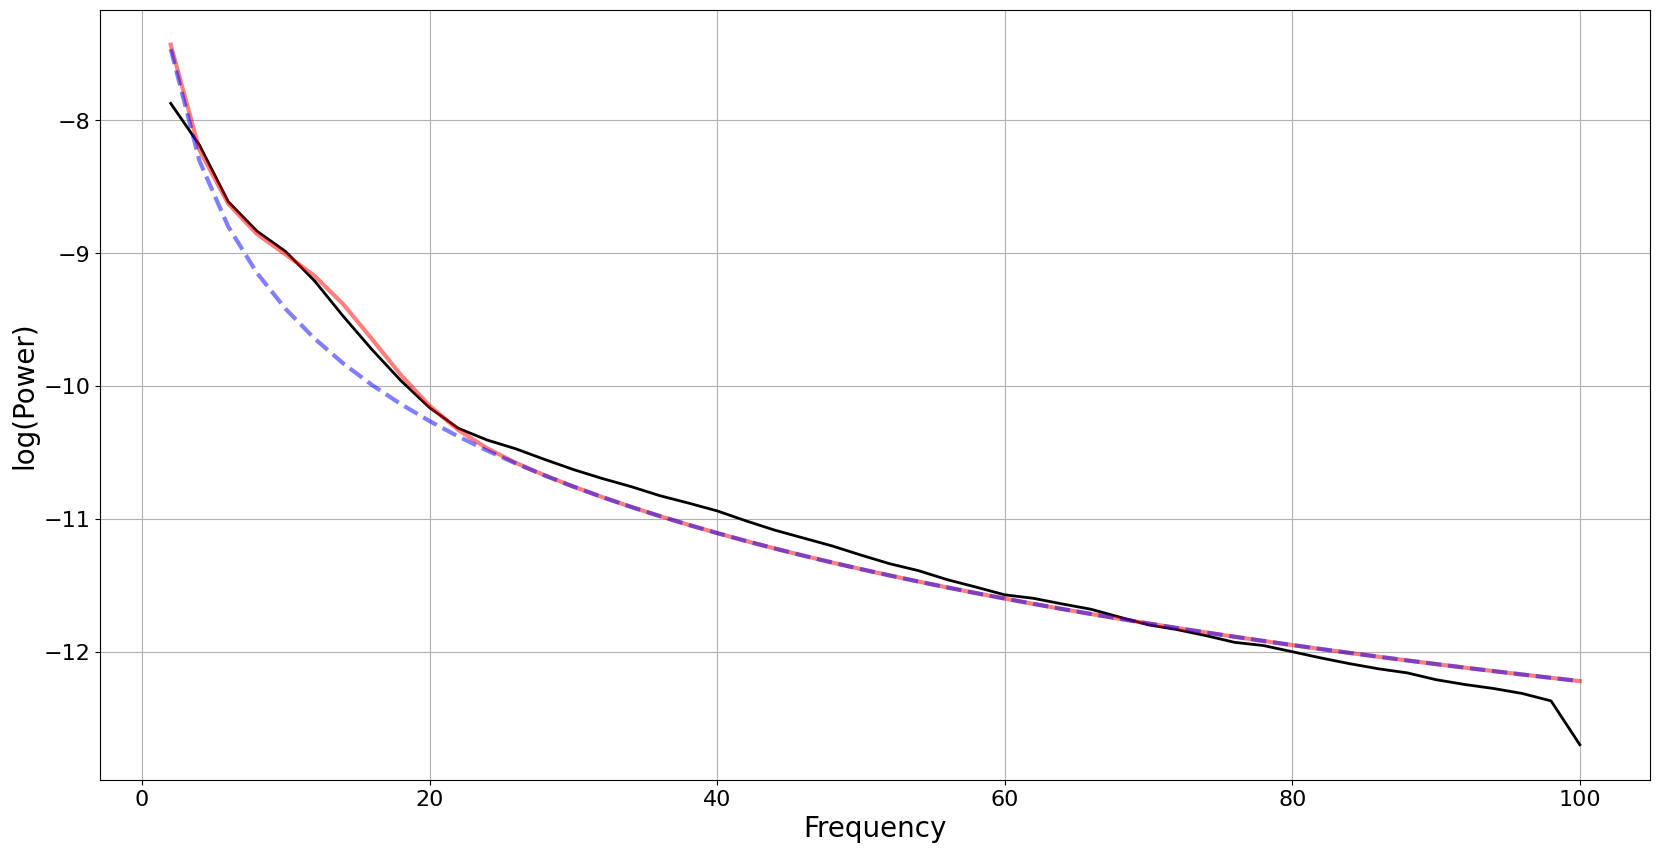

In [33]:
fig, ax = plt.subplots(figsize=(20, 10)) 

peak_vals_ecog_fulls = []
for spectrum in spectra:
    # For ECoG power spectrum, compute FOOOF model
    fm = FOOOF(verbose=False)
    fm.fit(freqs, spectrum, freq_range=(1, 100))
    fm.plot(ax = ax, add_legend=False)

    break
    # Get peak frequency
    peak_freq_ecog_full = get_band_peak_fm(fm, [1, 100], select_highest=True)
    freqs_gen = gen_freqs(freq_range=[0,100], freq_res=1)
    peak_vals_ecog_full = gauss(peak_freq_ecog_full[0],peak_freq_ecog_full[1], freqs_gen)
    peak_vals_ecog_fulls.append(peak_vals_ecog_full)

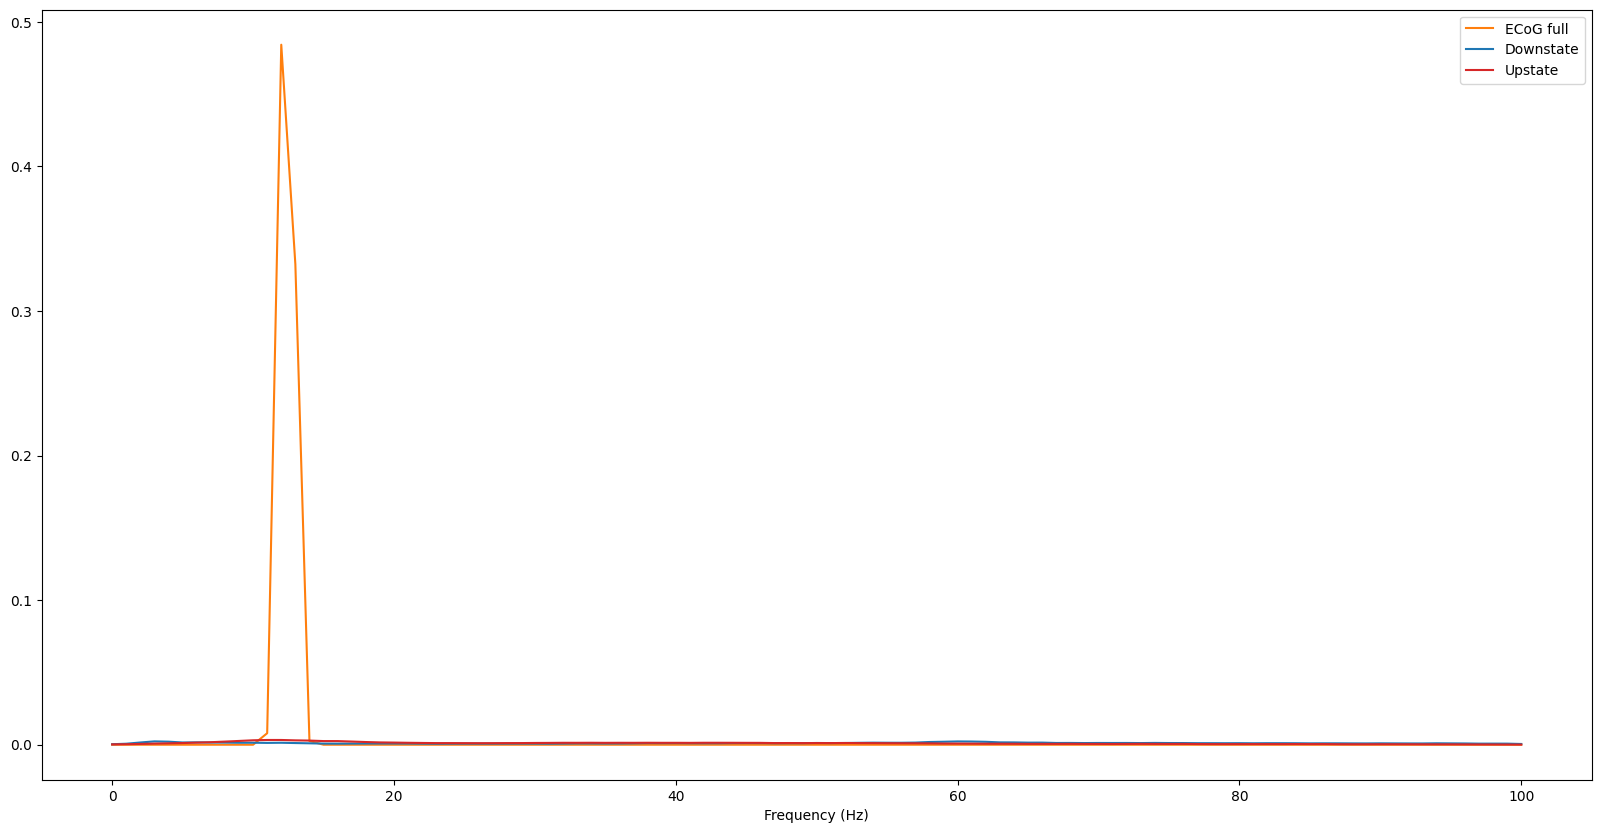

In [47]:
# Get peak frequency
peak_freq_ecog_full = get_band_peak_fm(fm, [1, 100])
freqs = gen_freqs(freq_range=[0,100], freq_res=1)
peak_vals_ecog_full = gauss(peak_freq_ecog_full[0],peak_freq_ecog_full[1],freqs)

freqs = gen_freqs(freq_range=[0,100], freq_res=1)

upstate_data = upstate_data_no_nun
downstate_data = downstate_data_no_nun

upstate_peak_vals = []
for cf, bw, pw in zip(upstate_data['Central frequencies'], upstate_data['Bandwidths'], upstate_data['Peak powers']):
    peak_vals = gauss(cf,bw,freqs)
    upstate_peak_vals.append(peak_vals)
    
downstate_peak_vals = []
for cf, bw, pw in zip(downstate_data['Central frequencies'], downstate_data['Bandwidths'], downstate_data['Peak powers']):
    peak_vals = gauss(cf,bw,freqs)
    downstate_peak_vals.append(peak_vals)
    
downstate_peak_vals = np.array(downstate_peak_vals)
downstate_peak_vals_mean = np.mean(downstate_peak_vals, axis=0)

upstate_peak_vals_mean = np.mean(upstate_peak_vals, axis=0)

plt.figure(figsize=(20, 10))
plt.plot(freqs, peak_vals_ecog_full, label = 'ECoG full', color='tab:orange')
plt.plot(freqs, downstate_peak_vals_mean, label = 'Downstate', color='tab:blue')
plt.plot(freqs, upstate_peak_vals_mean, label = 'Upstate', color='tab:red')
# plt.yscale('log')
plt.legend()
# plt.ylim(0, 0.1)
plt.xlabel('Frequency (Hz)')
plt.show()